## Description:

    Use DeSeq2 to identify differential abundance between hybrids 
    Remove outlier points from ordination
   


# Setting variables

In [1]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan", "RColorBrewer")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.0’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’


In [4]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


In [5]:
%%R
register(MulticoreParam(20))

## Loading phyloseq object

In [6]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [8]:
%%R


#remove BARE soil controls and untreated seeds
physeq.plant = subset_samples(physeq.Full, Genotype != "BARE" & SeedTreatment == "Treated")


# Remove ordination outliers, see Ordination notebook
physeq.plant = subset_samples(physeq.plant, !X.sampleID %in% c("ERA-T2_1-4c_85", "ERA-T2_4-4d_85"))


# Set rep and R_Year as a factor
sample_data(physeq.plant)$Rep = factor(sample_data(physeq.plant)$Rep) 
sample_data(physeq.plant)$R_Year = factor(sample_data(physeq.plant)$R_Year)  




#re-order levels 
sample_data(physeq.plant)$R_Year %>% levels


 [1] "1936" "1939" "1942" "1953" "1961" "1971" "1975" "1984" "1991" "2001"
[11] "2003" "2011"


# differential abundance at T1

In [9]:
%%R
physeq.plant.t1 = subset_samples(physeq.plant, TimePoint == "T1")
sample_data(physeq.plant.t1)$Plant = relevel(sample_data(physeq.plant.t1)$Plant, "1939" )
sample_data(physeq.plant.t1)$Fert = as.factor(sample_data(physeq.plant.t1)$Fert)
sample_data(physeq.plant.t1)$Rep = as.factor(sample_data(physeq.plant.t1)$Rep)

In [10]:
%%R

diagdds = phyloseq_to_deseq2(physeq.plant.t1, ~ Rep + Fert + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/brya

In [12]:
%%R
resultsNames(diagdds)

 [1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "Fert0"    
 [7] "Fert85"    "Fert170"   "Plant1939" "Plant1953" "Plant1971" "Plant1984"
[13] "Plant2001" "Plant2011"


In [15]:
%%R
#Function for gathering results

get_res = function(diagdds, plant) {
    r = results(diagdds, contrast=c("Plant", plant, "1939"), independentFiltering = TRUE, parallel = TRUE)
    #r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "lfcSE", "pvalue", "padj")])
    df$OTU = rownames(df)
    df$Plant = plant
    
    return(df)
}

In [13]:
%%R
Plants = c("1953","1971","1984", "2001","2011")

In [16]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}
df_plant$TimePoint = "T1"
df_plant.t1 = df_plant

t.df = tax_table(physeq.plant.t1) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

df_plant.t1 = left_join(df_plant.t1, t.df, by = "OTU")

In [17]:
%%R
#df_plant.t1$p.adj = p.adjust(df_plant.t1$pvalue, "BH")
head(df_plant.t1) %>% print
tail(df_plant.t1) %>% print



    baseMean log2FoldChange     lfcSE    pvalue padj       OTU Plant TimePoint
1  8.7507877    0.142186210 0.2720088 0.6011645    1   OTU.871  1953        T1
2  0.3159718   -0.050914616 0.2646183 0.8474228    1  OTU.9547  1953        T1
3 15.8508860    0.005701919 0.2331705 0.9804906    1   OTU.523  1953        T1
4  2.2112584   -0.356657463 0.3738225 0.3400420    1  OTU.1107  1953        T1
5  1.0661659   -0.033434869 0.4072093 0.9345614    1 OTU.11742  1953        T1
6  3.2391696   -0.402978411 0.3715884 0.2781541    1  OTU.1889  1953        T1
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxoc

In [20]:
%%R -w 900 -h 1200

colourCount = length(unique(df_plant.t1$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

#df.adj = df_plant.t1[!is.na(df_plant.t1$padj),]
df.sig = df_plant.t1[df_plant.t1$padj < .1,]
df.ns = df_plant.t1[df_plant.t1$padj >= .1,]

p = ggplot(df_plant.t1)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "Gray", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
               #geom_hline(y_intercept = .4) +
    
    facet_wrap(~Plant)+
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))

   

## l2f between hybrids at T2

In [21]:
%%R
physeq.plant.t2 = subset_samples(physeq.plant, TimePoint == "T2")
sample_data(physeq.plant.t2)$Plant = relevel(sample_data(physeq.plant.t2)$Plant, "1936" )
sample_data(physeq.plant.t2)$Fert = as.factor(sample_data(physeq.plant.t2)$Fert)
sample_data(physeq.plant.t2)$Rep = as.factor(sample_data(physeq.plant.t2)$Rep)

In [22]:
%%R

diagdds = phyloseq_to_deseq2(physeq.plant.t2, ~ Rep  + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

In [23]:
%%R
resultsNames(diagdds)

 [1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "Plant1936"
 [7] "Plant1939" "Plant1942" "Plant1953" "Plant1961" "Plant1971" "Plant1975"
[13] "Plant1984" "Plant1991" "Plant2001" "Plant2003" "Plant2011"


In [24]:
%%R
#Function for gathering results

get_res = function(diagdds, plant) {
    r = results(diagdds, contrast=c("Plant", plant, "1936"), independentFiltering = TRUE, parallel = TRUE)
    #r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "lfcSE", "pvalue", "padj")])
    df$OTU = rownames(df)
    df$Plant = plant
    
    return(df)
}

In [26]:
%%R
Plants = sample_data(physeq.plant.t2)$Plant %>% levels %>% .[c(2:12)] 
Plants

 [1] "1939" "1942" "1953" "1961" "1971" "1975" "1984" "1991" "2001" "2003"
[11] "2011"


In [27]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}
df_plant$TimePoint = "T2"
df_plant.t2 = df_plant

t.df = tax_table(physeq.plant.t2) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

df_plant.t2 = left_join(df_plant.t2, t.df, by = "OTU")

In [28]:
%%R
#df_plant.t1$p.adj = p.adjust(df_plant.t1$pvalue, "BH")
head(df_plant.t2) %>% print
tail(df_plant.t2) %>% print



    baseMean log2FoldChange     lfcSE     pvalue padj       OTU Plant TimePoint
1  6.7818683    -0.89674793 0.5437731 0.09912276    1   OTU.871  1939        T2
2  0.5462976    -0.38253934 0.4414005 0.38613432    1  OTU.9547  1939        T2
3 15.7235779    -0.08419452 0.3373950 0.80294088    1   OTU.523  1939        T2
4  2.9545293     0.35363005 0.6034323 0.55785466    1  OTU.1107  1939        T2
5  0.8649499     0.09464134 0.6198731 0.87865176    1 OTU.11742  1939        T2
6  1.8121440     0.49466826 0.6290849 0.43167423    1  OTU.1889  1939        T2
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria 

# l2fc at T3

In [29]:
%%R
physeq.plant.t3 = subset_samples(physeq.plant, TimePoint == "T3")
sample_data(physeq.plant.t3)$Plant = relevel(sample_data(physeq.plant.t3)$Plant, "1939" )
sample_data(physeq.plant.t3)$Fert = as.factor(sample_data(physeq.plant.t3)$Fert)
sample_data(physeq.plant.t3)$Rep = as.factor(sample_data(physeq.plant.t3)$Rep)


In [30]:
%%R

diagdds = phyloseq_to_deseq2(physeq.plant.t3, ~ Rep + Fert + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")



In [31]:
%%R
resultsNames(diagdds)

 [1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "Fert0"    
 [7] "Fert85"    "Fert170"   "Plant1939" "Plant1953" "Plant1971" "Plant1984"
[13] "Plant2001" "Plant2011"


In [32]:
%%R
Plants = sample_data(physeq.plant.t3)$Plant %>% levels %>% .[2:6]
Plants

[1] "1953" "1971" "1984" "2001" "2011"


In [33]:
%%R
#Function for gathering results

get_res = function(diagdds, plant) {
    r = results(diagdds, contrast=c("Plant", plant, "1939"), independentFiltering = TRUE, parallel = TRUE)
    #r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "lfcSE", "pvalue", "padj")])
    df$OTU = rownames(df)
    df$Plant = plant
    
    return(df)
}

In [34]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}
df_plant$TimePoint = "T3"
df_plant.t3 = df_plant

t.df = tax_table(physeq.plant.t3) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

df_plant.t3 = left_join(df_plant.t3, t.df, by = "OTU")

In [35]:
%%R
df_plant.t3 %>% head

    baseMean log2FoldChange     lfcSE     pvalue      padj       OTU Plant
1  7.0919597     0.31880281 0.2898770 0.27142509 0.8270406   OTU.871  1953
2  0.5654074    -0.80113538 0.4210341 0.05706921        NA  OTU.9547  1953
3 14.6904237    -0.15689503 0.2055438 0.44527442 0.9068800   OTU.523  1953
4  2.9451143     0.02519882 0.3731934 0.94616603 0.9947984  OTU.1107  1953
5  1.1655532     0.99130934 0.4282622 0.02062797 0.5101085 OTU.11742  1953
6  2.4309638     0.02890180 0.3686504 0.93751070 0.9947984  OTU.1889  1953
  TimePoint    Rank1            Rank2                 Rank3          Rank4
1        T3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2        T3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3        T3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4        T3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5        T3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6        T3 Bacteria __Pr

## normalized depth at each time point

In [36]:
%%R
df_plant.t1 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T1") %>% print

df_plant.t2 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T2") %>% print

df_plant.t3 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T3") %>% print

[1] "30141.0035102652 normalized reads at T1"
[1] "32543.8985184371 normalized reads at T2"
[1] "33535.0243078956 normalized reads at T3"


In [ ]:
# Join timepoints

In [37]:
%%R
df_all = bind_rows(df_plant.t1, df_plant.t2, df_plant.t3)

In [38]:
%%R -i workDir


write.csv(df_all, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/EarlyReleasevsYear.csv", row.names = FALSE, sep = ",")

# Graph changes at T2

In [39]:
%%R
df.l2fc = read.csv("/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/EarlyReleasevsYear.csv", header = TRUE)

In [40]:
%%R
df.l2fc %>% filter(padj < 0.05) %>% head

   baseMean log2FoldChange     lfcSE       pvalue        padj       OTU Plant
1  7.665748      -1.698689 0.3993900 2.107304e-05 0.024764686  OTU.3521  1971
2 13.174639      -1.642173 0.3937016 3.031173e-05 0.024764686 OTU.11534  1971
3  9.123596      -1.644914 0.4071804 5.350445e-05 0.032784852  OTU.4313  1971
4  6.898065       1.491062 0.3472081 1.751406e-05 0.024764686   OTU.808  1971
5  3.337030      -1.662755 0.3549319 2.803505e-06 0.006372368   OTU.948  2001
6 12.065722      -1.557657 0.3803000 4.205950e-05 0.047800621   OTU.399  2001
  TimePoint    Rank1            Rank2                 Rank3
1        T1 Bacteria __Proteobacteria  __Betaproteobacteria
2        T1 Bacteria __Proteobacteria __Gammaproteobacteria
3        T1 Bacteria __Proteobacteria __Gammaproteobacteria
4        T1 Bacteria __Actinobacteria __Propionibacteriales
5        T1 Bacteria __Proteobacteria __Alphaproteobacteria
6        T1 Bacteria __Proteobacteria  __Betaproteobacteria
                   Rank4          

In [41]:
%%R
# YR = sample_data(physeq.Full) %>%
#     filter(SeedTreatment != "Untreated" & Plant != "Bare") %>%
#     as.data.frame() %>%
#     select(Plant, R_Year) %>%
#     unique %>% 
#     filter(Plant!= "1936")

# YR


   Plant R_Year
1   2011   2011
2   2001   2001
3   1939   1939
4   1953   1953
5   1971   1971
6   1984   1984
7   1975   1975
8   1961   1961
9   1991   1991
10  2003   2003
11  1942   1942


In [42]:
# %%R
# DF = df.l2fc %>% filter(TimePoint == "T2")  %>% as.data.frame()
# DF = left_join(DF, YR, by = "Plant")
# DF =  mutate(DF, Plant = reorder(Plant,R_Year))
# levels(DF$Plant)


Error in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y) : 
  Can't join on 'Plant' x 'Plant' because of incompatible types (factor / integer)


/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y) : 
  Can't join on 'Plant' x 'Plant' because of incompatible types (factor / integer)

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In brewer.pal(10, "Dark2") :
  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors


  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/

In [43]:
%%R
# DF$R_Year %>% unique

NULL


In [50]:
%%R
# Identify top 9 phyla to graph
Phy_toKeep = physeq.plant %>% 
    psmelt() %>%
    group_by(Rank2) %>%
    summarize(Phy_Abund = sum(Abundance)) %>%
    arrange(desc(Phy_Abund)) %>%
    as.data.frame() %>%
    .[1:9,] %>%
    .$Rank2 

In [51]:
%%R
Phy_toKeep

[1] __Actinobacteria   __Proteobacteria   __Acidobacteria    __Chloroflexi     
[5] __Planctomycetes   __Verrucomicrobia  __Bacteroidetes    __Gemmatimonadetes
[9] __Firmicutes      
29 Levels: __Acidobacteria __Actinobacteria ... __WCHB1-60


In [52]:
%%R
# Define tree color palete
TreeColors = c("#1f78b4", #acidobacteria, 
               "#9a9a00", #Actinobacteria, 
                "#4b0082",  #Bacteroidetes,
               #"#cc4392", #Candidate WS3, 
               "#ff0000",  #Chloroflexi, 
               #"#e31a1c", #Cyanobacteria, 
                '#ffff00', #firmicutes
              "#ff8000",  #Gemmatoidetes, 
             #  "#000000",  #"JL-ETNP-Z39", 
               #"#000000", #Nitrospirae
             "#00ff00", #Planctomycetes,
               "#008000", #proteobacteria 
              "#299a9f")  #Verrucomicrobia

In [53]:
%%R
# Identify phyla to remove from figure by low base mean and low l2f
# Phy_toKeep = DF %>% group_by(Rank2) %>%
#     summarize(Filter = max(baseMean < 20) & max(abs(log2FoldChange)) < 1 ) %>%
#     filter(Filter == FALSE) %>%
#     .[,"Rank2"] %>% 
#     as.list()


#

DF.p = filter(DF, Rank2 %in% Phy_toKeep & !is.na(Plant))
DF.p$Rank2 = droplevels(DF.p$Rank2)
DF.p$Rank2 = gsub("__", "", DF.p$Rank2)
#DF.p$R_Year = droplevels(DF.p$R_Year)

In [54]:
%%R
head(DF.p)

    baseMean log2FoldChange     lfcSE     pvalue padj       OTU Plant TimePoint
1  6.7818683    -0.89674793 0.5437731 0.09912276    1   OTU.871  1939        T2
2  0.5462976    -0.38253934 0.4414005 0.38613432    1  OTU.9547  1939        T2
3 15.7235779    -0.08419452 0.3373950 0.80294088    1   OTU.523  1939        T2
4  2.9545293     0.35363005 0.6034323 0.55785466    1  OTU.1107  1939        T2
5  0.8649499     0.09464134 0.6198731 0.87865176    1 OTU.11742  1939        T2
6  1.8121440     0.49466826 0.6290849 0.43167423    1  OTU.1889  1939        T2
     Rank1          Rank2                 Rank3          Rank4            Rank5
1 Bacteria Proteobacteria __Deltaproteobacteria __Myxococcales __Nannocystineae
2 Bacteria Proteobacteria __Deltaproteobacteria __Myxococcales __Nannocystineae
3 Bacteria Proteobacteria __Deltaproteobacteria __Myxococcales __Nannocystineae
4 Bacteria Proteobacteria __Deltaproteobacteria __Myxococcales __Nannocystineae
5 Bacteria Proteobacteria __Deltaproteob

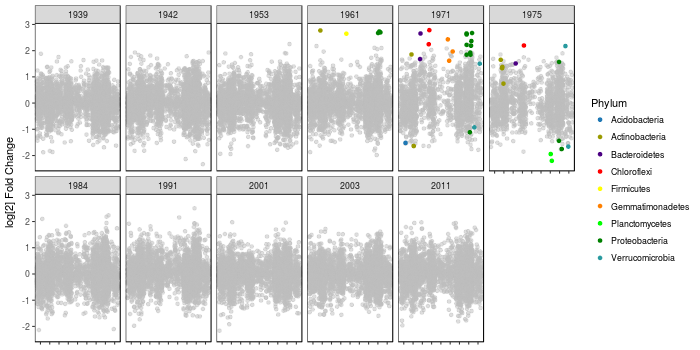

In [55]:
%%R -w 700 -h 350


#df.adj = df_plant.t1[!is.na(df_plant.t1$padj),]

df.sig = DF.p %>% filter(padj < 0.05)
df.ns = DF.p %>% filter(padj >= 0.05)

#colourCount = length(unique(DF.p$Rank2)) + 1
#getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(DF.p)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange), color = "Grey", alpha = 0.5, position = "jitter") +
    scale_shape_identity() +
       geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2),position = "jitter") +
               #geom_hline(y_intercept = .4) +
    facet_wrap(~Plant, ncol = 6)+
    theme_pub() +
    
    theme(axis.text.x = element_blank(), axis.title.x = element_blank())+#element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") +
    guides(color = guide_legend(title = "Phylum"))

p = p + scale_color_manual(values = TreeColors)

p


In [26]:
%%R
svg(filename = '/home/bryan/ERA/data/figures/ms_versions/Figure5_ms.svg', width = 7.086, height = 3.5)
p %>% print
dev.off()

png 
  2 


In [27]:
%%R
svg(filename = '/home/bryan/ERA/data/figures/ms_versions/Figure5_diss.svg', width = 6.5, height = 3.25)
p %>% print
dev.off()

png 
  2 


In [56]:
%%R
 df.sig$OTU %>% unique %>% length
#df.sig

[1] 38


## Create metrics and tables by timepoint

In [58]:
%%R

# Explore rhizosphere responders after multiple comparison correction across all comps
sig = df.l2fc %>% filter(padj < 0.05 )

print(paste("OTUs differentially abundant from earliest hybrid sampled: ", 
            sig$OTU %>% unique %>% length, sep = ""))

sig.t1 = df.l2fc %>% filter(padj < 0.05 & TimePoint == "T1")
print(paste("OTUs differentially abundant from earliest hybrid sampled: ", sig.t1$OTU %>% unique %>% length, sep = ""))

sig.t2 = df.l2fc %>% filter(padj < 0.05  & TimePoint == "T2")
print(paste("OTUs differentially abundant from earliest hybrid sampled: ", sig.t2$OTU %>% unique %>% length, sep = ""))

sig.t3 = df.l2fc %>% filter(padj < 0.05 &   TimePoint == "T3")
print(paste("OTUs differentially abundant from earliest hybrid sampled: ", sig.t3$OTU %>% unique %>% length, sep = ""))


[1] "OTUs differentially abundant from earliest hybrid sampled: 48"
[1] "OTUs differentially abundant from earliest hybrid sampled: 6"
[1] "OTUs differentially abundant from earliest hybrid sampled: 38"
[1] "OTUs differentially abundant from earliest hybrid sampled: 4"


In [59]:
%%R
sig.t1 

   baseMean log2FoldChange     lfcSE       pvalue        padj       OTU Plant
1  7.665748      -1.698689 0.3993900 2.107304e-05 0.024764686  OTU.3521  1971
2 13.174639      -1.642173 0.3937016 3.031173e-05 0.024764686 OTU.11534  1971
3  9.123596      -1.644914 0.4071804 5.350445e-05 0.032784852  OTU.4313  1971
4  6.898065       1.491062 0.3472081 1.751406e-05 0.024764686   OTU.808  1971
5  3.337030      -1.662755 0.3549319 2.803505e-06 0.006372368   OTU.948  2001
6 12.065722      -1.557657 0.3803000 4.205950e-05 0.047800621   OTU.399  2001
  TimePoint    Rank1            Rank2                 Rank3
1        T1 Bacteria __Proteobacteria  __Betaproteobacteria
2        T1 Bacteria __Proteobacteria __Gammaproteobacteria
3        T1 Bacteria __Proteobacteria __Gammaproteobacteria
4        T1 Bacteria __Actinobacteria __Propionibacteriales
5        T1 Bacteria __Proteobacteria __Alphaproteobacteria
6        T1 Bacteria __Proteobacteria  __Betaproteobacteria
                   Rank4          

In [60]:
%%R
write.csv(sig.t1, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t1.csv")

In [61]:
%%R
sig.t2 = sig.t2 %>%
    arrange(Rank2,log2FoldChange)

In [62]:
%%R
write.csv(sig.t2, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t2.csv")
write.csv(sig.t3, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t3.csv")

## How abundant are OTUs that are differentially abundant in release year 1971

In [63]:
%%R
phy.snorm = readRDS("/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_snorm.rds")
phy.snorm = subset_samples(phy.snorm, SeedTreatment == "Treated"& TimePoint != "T0" )
phy.snorm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [64]:
%%R
phy.1971 = subset_samples(phy.snorm, R_Year %in% c(1936,1939,1971))
phy.1971

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 60 samples ]
sample_data() Sample Data:       [ 60 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [65]:
%%R
TaxList = df.l2fc %>% 
    filter(padj < 0.05) %>%
    .$OTU %>%
    unique %>%
    as.character()

In [66]:
%%R
mdf = psmelt(phy.snorm)

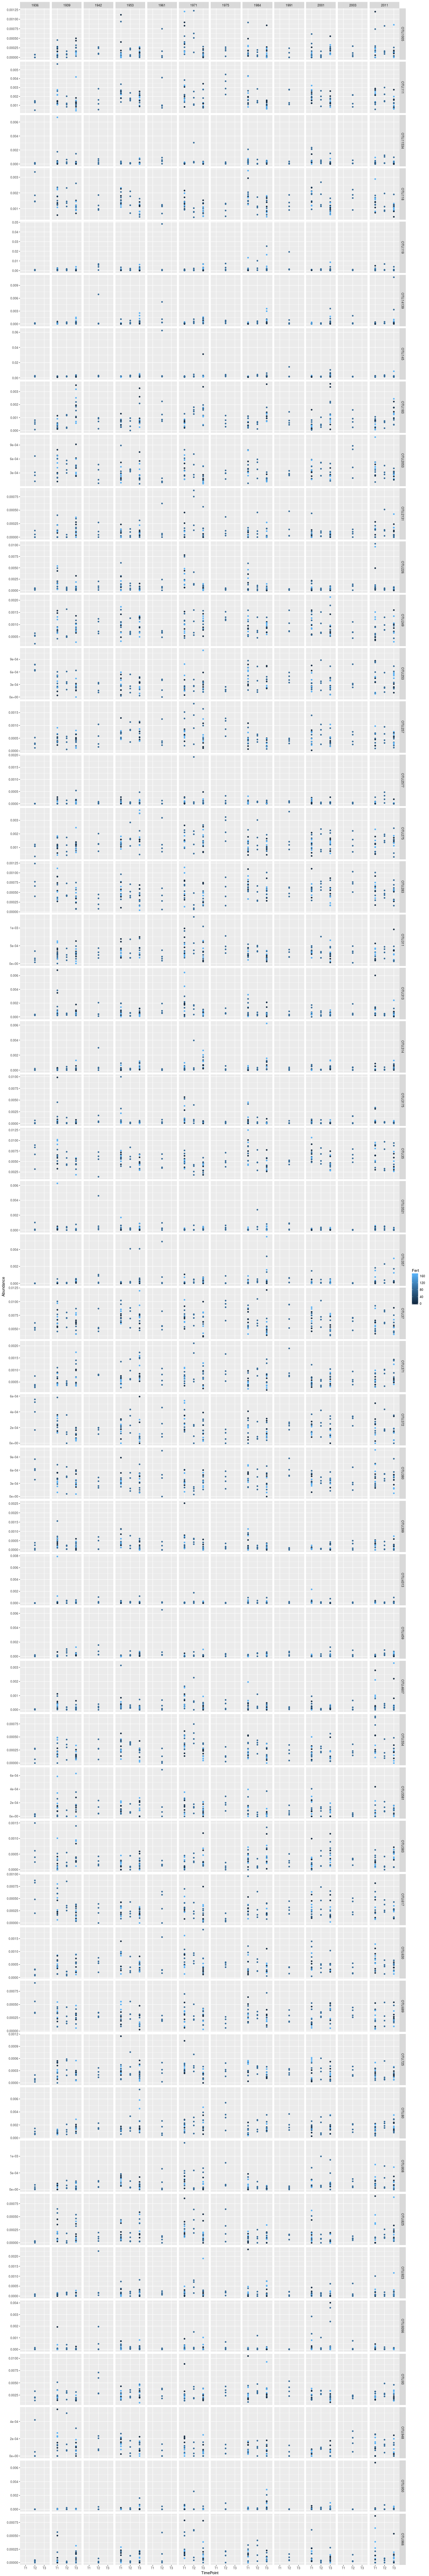

In [67]:
%%R -w 1200 -h 7200
mdf %>%
    filter(OTU %in%  TaxList) %>%
    ggplot(aes(x = TimePoint, y = Abundance, color = Fert)) +
    geom_point()+
    facet_grid(OTU~R_Year, scales = "free_y")

In [77]:
%%R
ToKeep = sig$OTU %>% unique %>% as.character

mdf.t1 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t1)


Source: local data frame [6 x 5]
Groups: Plant, R_Year [1]

   Plant R_Year       OTU       mAbund      seAbund
  <fctr>  <int>     <chr>        <dbl>        <dbl>
1   1936   1936  OTU.1005 3.565455e-05 2.059452e-05
2   1936   1936   OTU.111 1.165504e-03 2.417984e-04
3   1936   1936 OTU.11534 9.738617e-05 3.900693e-05
4   1936   1936   OTU.118 2.023164e-03 4.463725e-04
5   1936   1936   OTU.119 5.398100e-04 1.601638e-04
6   1936   1936 OTU.14139 1.012116e-04 4.150320e-05


In [78]:
%%R -w 700 -h 300
pT1 = ggplot(mdf.t1, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())

## Plot OTUs differentially abundant at T2

In [79]:
%%R
ToKeep = sig.t2$OTU %>% unique %>% as.character
mdf.t2 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t2)
 

Source: local data frame [6 x 5]
Groups: Plant, R_Year [1]

   Plant R_Year       OTU       mAbund      seAbund
  <fctr>  <int>     <chr>        <dbl>        <dbl>
1   1936   1936  OTU.1005 3.565455e-05 2.059452e-05
2   1936   1936   OTU.111 1.165504e-03 2.417984e-04
3   1936   1936   OTU.118 2.023164e-03 4.463725e-04
4   1936   1936   OTU.119 5.398100e-04 1.601638e-04
5   1936   1936 OTU.14139 1.012116e-04 4.150320e-05
6   1936   1936   OTU.145 1.953833e-03 2.902625e-04


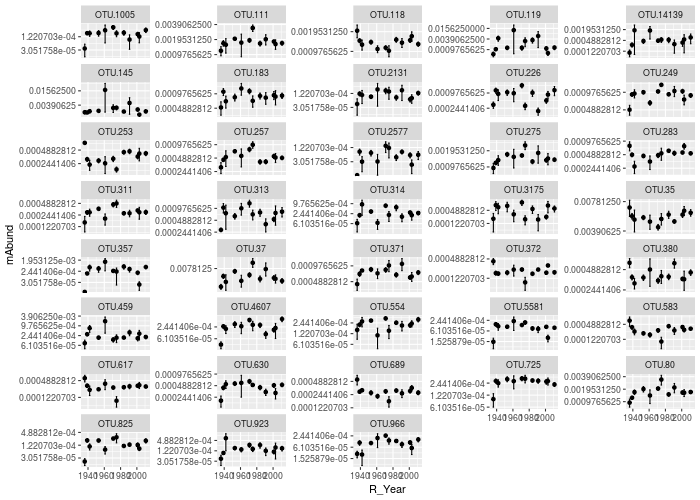

In [80]:
%%R -w 700 -h 500
pT2 = ggplot(mdf.t2, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())
pT2

### Plot OTUs differentially abundant at T3

In [81]:
%%R
ToKeep = sig.t3$OTU %>% unique %>% as.character
mdf.t3 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t3)


Source: local data frame [6 x 5]
Groups: Plant, R_Year [2]

   Plant R_Year      OTU       mAbund      seAbund
  <fctr>  <int>    <chr>        <dbl>        <dbl>
1   1936   1936 OTU.2053 3.370324e-04 1.157975e-04
2   1936   1936 OTU.9266 4.513841e-05 3.450164e-05
3   1936   1936   OTU.93 2.178700e-03 3.996600e-04
4   1936   1936  OTU.950 0.000000e+00 0.000000e+00
5   1939   1939 OTU.2053 4.386668e-04 3.738307e-05
6   1939   1939 OTU.9266 1.280800e-04 7.001465e-05


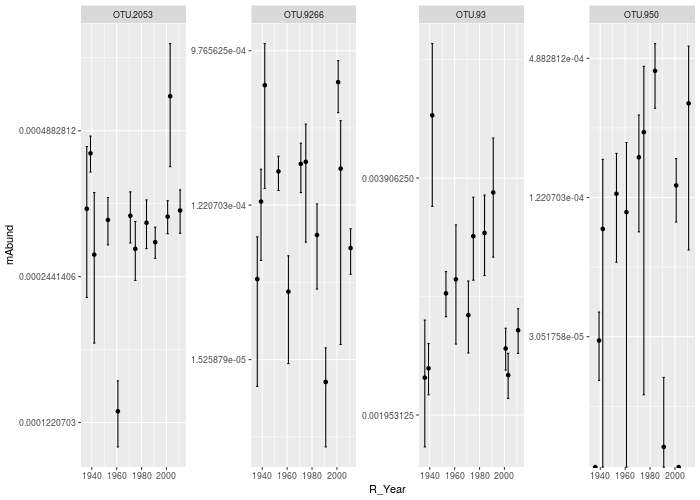

In [82]:
%%R -w 700 -h 500
pT3 = ggplot(mdf.t3, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())
pT3